In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import os

# Set the environment variable OMP_NUM_THREADS to 1
os.environ["OMP_NUM_THREADS"] = "1"

from sklearn.cluster import KMeans

In [3]:
views_en = pd.read_csv('data/Philo_en.csv')
views_lang = pd.read_csv('data/Philos_lang.csv')

### Preprocessing 

In [4]:
# Rename rows with wrong country code 

views_lang['code'] = views_lang['project'].str.split('.').str[0]
views_en['code'] = views_en['project'].str.split('.').str[0]
views_en['subject'] = views_en['article']

In [5]:
#Filter the code to get topics present in all language 

article_counts = views_lang.groupby('subject')['code'].nunique()
articles_to_keep = article_counts[article_counts == views_lang['code'].nunique()].index.tolist()
views_lang_filtered = views_lang[views_lang['subject'].isin(articles_to_keep)]

In [6]:
def compute_fraction_per_lang(views):
    
    grouped = views.groupby(['code', 'project'])['views'].sum()
    articles = views.groupby(['code','subject'])['views'].sum()

    grouped = grouped.to_frame(name='views_count_by_language').reset_index()
    articles = articles.to_frame(name='views_count_by_article').reset_index()

    merged_df = pd.merge(articles, grouped[['code','views_count_by_language']], on='code', how='left')
    merged_df['fraction_of_views'] = merged_df['views_count_by_article'] / merged_df['views_count_by_language']
    
    return merged_df

In [7]:
def compute_cluster(fraction_views, nb_cluster) : 
    fraction_views_clustered = fraction_views.copy()
    kmeans = KMeans(nb_cluster, n_init= 10)
    kmeans.fit(fraction_views_clustered)
    fraction_views_clustered = kmeans.labels_
    return fraction_views_clustered

In [8]:
fraction_views_lang = compute_fraction_per_lang(views_lang_filtered)
#fraction_views_en = compute_fraction_per_lang(views_en)

In [87]:
NB_CLUSTER = 2

arr = np.vstack(fraction_views_lang.groupby('code')['fraction_of_views'].apply(lambda x: x.to_numpy()).to_numpy()).astype(float)
clusters = compute_cluster(arr, NB_CLUSTER)
lang_clusters = pd.DataFrame({'Cluster_Labels': clusters, 'Country_Codes': fraction_views_lang['code'].unique()})

for cluster_label, group in lang_clusters.groupby('Cluster_Labels'):
    country_names = ', '.join(group['Country_Codes'])
    print(f'Cluster {cluster_label}: {country_names}')

Cluster 0: da, fi, ko, nl, no, sr, sv
Cluster 1: de, fr, it, ja


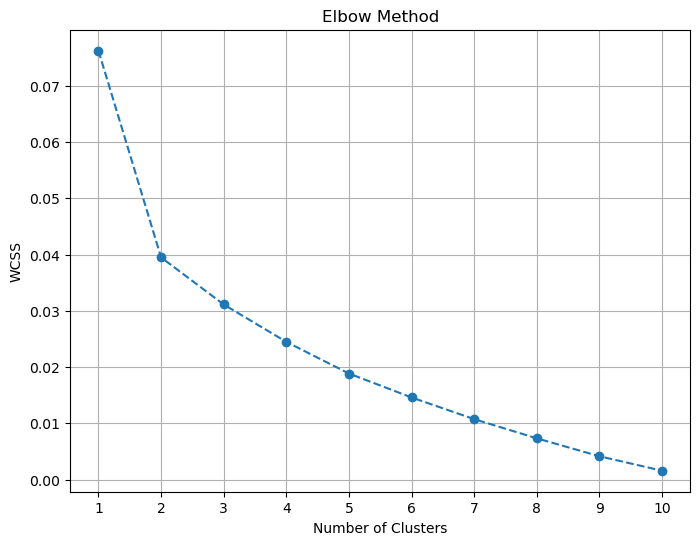

In [10]:
wcss = []
for i in range(1, 11):  # Trying different numbers of clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init= 10)
    kmeans.fit(arr)
    wcss.append(kmeans.inertia_)  # Inertia is the within-cluster sum of squares

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 11, 1))  # Setting x-axis ticks from 1 to 10
plt.grid()

## Same but for each period

In [76]:
interventions = pd.read_csv('data/interventions.csv')
interventions = interventions.drop(9)
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
5,no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
6,sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
7,sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
8,ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15
10,fi,2020-01-29,2020-03-21,2020-03-16,2020-03-16,NaN,2020-03-16,2020-05-21


In [77]:
interventions['Mobility'] = pd.to_datetime(interventions['Mobility'])
interventions['Normalcy'] = pd.to_datetime(interventions['Normalcy'])

interventions['Mobility']  = interventions['Mobility'].dt.strftime('%Y%m%d').astype('int64')
interventions['Normalcy']  = interventions['Normalcy'].dt.strftime('%Y%m%d').astype('int64')

threshold_date_before = interventions[['lang','Mobility']]
threshold_date_after = interventions[['lang','Normalcy']]

In [70]:
threshold_date_after

,lang,Mobility
0,fr,20200316
1,da,20200311
2,de,20200316
3,it,20200311
4,nl,20200316
5,no,20200311
6,sr,20200316
7,sv,20200311
8,ko,20200225
9,ca,20200316


In [79]:
views_lang

,project,article,timestamp,views,subject,code
0,fr.wikipedia,Absurde,2018010100,10119,Absurdism,fr
1,fr.wikipedia,Absurde,2018020100,8507,Absurdism,fr
2,fr.wikipedia,Absurde,2018030100,9485,Absurdism,fr
3,fr.wikipedia,Absurde,2018040100,9772,Absurdism,fr
4,fr.wikipedia,Absurde,2018050100,11073,Absurdism,fr
...,...,...,...,...,...,...
154616,fi.wikipedia,Zurvalaisuus,2022080100,64,Naïve realism,fi
154617,fi.wikipedia,Zurvalaisuus,2022090100,51,Naïve realism,fi
154618,fi.wikipedia,Zurvalaisuus,2022100100,33,Naïve realism,fi
154619,fi.wikipedia,Zurvalaisuus,2022110100,36,Naïve realism,fi


In [80]:
before_threshold = views_lang[views_lang['timestamp'] < threshold_date_before]
between_thresholds = views_lang[(views_lang['timestamp'] >= threshold_date_before) & (views_lang['timestamp'] <= threshold_date_after)]
after_threshold = views_lang[views_lang['timestamp'] > threshold_date_after]

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.